<a href="https://colab.research.google.com/github/chrisandoryan/Camstroke-Inference/blob/main/Camstroke_Inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import and Declaration

In [ ]:
pip install ipyparallel

In [ ]:
from math import log
import random
import sys
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import os
import pickle
import csv
import shlex
from collections import Counter, defaultdict

from sklearn.model_selection import GroupShuffleSplit
from imblearn.under_sampling import RandomUnderSampler

import ipyparallel as ipp
import multiprocessing
from multiprocessing import Manager

# Model Builder

In [ ]:
latent_dim = 256  # Latent dimensionality of the encoding space.

def build_models(num_encoder_tokens, num_decoder_tokens):
    """
    ## Build the model
    """

    # Define an input sequence and process it.
    encoder_inputs = keras.Input(shape=(None, num_encoder_tokens))
    encoder = keras.layers.LSTM(latent_dim, return_state=True)
    encoder_outputs, state_h, state_c = encoder(encoder_inputs)

    # We discard `encoder_outputs` and only keep the states.
    encoder_states = [state_h, state_c]

    # Set up the decoder, using `encoder_states` as initial state.
    decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))

    # We set up our decoder to return full output sequences,
    # and to return internal states as well. We don't use the
    # return states in the training model, but we will use them in inference.
    decoder_lstm = keras.layers.LSTM(latent_dim, dropout=0.2, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)

    # dropout = keras.layers.Dropout(rate=0.2)
    # decoder_outputs = dropout(decoder_outputs)
    
    decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")
    decoder_outputs = decoder_dense(decoder_outputs)

    # Define the model that will turn
    # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
    model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

    return model

def load_models(path):
    """
    ## Run inference (sampling)

    1. encode input and retrieve initial decoder state
    2. run one step of decoder with this initial state
    and a "start of sequence" token as target.
    Output will be the next target token.
    3. Repeat with the current target token and current states
    """

    # Define sampling models
    # Restore the model and construct the encoder and decoder.
    model = keras.models.load_model(path)
    model.summary()

    encoder_inputs = model.input[0]  # input_1
    encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # lstm_1
    encoder_states = [state_h_enc, state_c_enc]
    encoder_model = keras.Model(encoder_inputs, encoder_states)

    decoder_inputs = model.input[1]  # input_2
    decoder_state_input_h = keras.Input(shape=(latent_dim,), name="input_7")
    decoder_state_input_c = keras.Input(shape=(latent_dim,), name="input_8")
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    decoder_lstm = model.layers[3]
    decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
        decoder_inputs, initial_state=decoder_states_inputs
    )
    decoder_states = [state_h_dec, state_c_dec]
    decoder_dense = model.layers[4]
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = keras.Model(
        [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
    )

    return model, encoder_model, decoder_model

# Training and Evaluation Preparation

## Parameter Configuration

In [ ]:
batch_size = 32  # Batch size for training.
epochs = 100  # Number of epochs to train for.

START_TOKEN = "\t"
END_TOKEN = "\n"

## Training Utilities

In [ ]:
def prepare(datasets, keydelay_tokens, keytext_tokens):
    # Vectorize the data.
    keydelay_inputs = []
    keytext_targets = []
    keydelay_tokens = sorted(list(keydelay_tokens))
    keytext_tokens = [START_TOKEN, END_TOKEN] + list(keytext_tokens)
    keytext_tokens = sorted(list(keytext_tokens))
    num_encoder_tokens = max(keydelay_tokens) + 1
    num_decoder_tokens = len(keytext_tokens)

    for d in datasets:
        # train_df, test_df = np.split(d, [int(.9*len(d))])
        keydelays = d['keydelay'].tolist()
        keytexts = d['key2'].tolist()
        keytexts = [START_TOKEN] + keytexts + [END_TOKEN]

        keydelays = to_categorical(keydelays, num_classes=num_encoder_tokens)
        keydelay_inputs.append(keydelays)
        keytext_targets.append(keytexts)

    max_encoder_seq_length = max([len(i) for i in keydelay_inputs])
    max_decoder_seq_length = max([len(t) for t in keytext_targets])

    print("Number of samples:", len(keydelay_inputs))
    print("Number of unique input tokens:", num_encoder_tokens)
    print("Number of unique output tokens:", num_decoder_tokens)
    print("Max sequence length for inputs:", max_encoder_seq_length)
    print("Max sequence length for outputs:", max_decoder_seq_length)

    input_token_index = dict([(char, i)
                              for i, char in enumerate(keydelay_tokens)])
    target_token_index = dict([(char, i)
                               for i, char in enumerate(keytext_tokens)])

    # one-hot encoding
    encoder_input_data = np.zeros(
        (len(keydelay_inputs), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
    )
    decoder_input_data = np.zeros(
        (len(keydelay_inputs), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
    )
    decoder_target_data = np.zeros(
        (len(keydelay_inputs), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
    )

    for i, (keydelay, keytext) in enumerate(zip(keydelay_inputs, keytext_targets)):
        encoder_input_data[i, 0:len(keydelay)] = keydelay

        for t, text in enumerate(keytext):
            # decoder_target_data is ahead of decoder_input_data by one timestep
            decoder_input_data[i, t, target_token_index[text]] = 1.0
            if t > 0:
                # decoder_target_data will be ahead by one timestep
                # and will not include the start character.
                decoder_target_data[i, t - 1, target_token_index[text]] = 1.0

        # what's this for?
        # i think this is to disregard the ' ' (on the tutorial they used target_token_index[' ']) so that the model won't predict it.
        # decoder_input_data[i, t + 1:, target_token_index['a']] = 1.0
        # decoder_target_data[i, t:, target_token_index['a']] = 1.0

    # print(encoder_input_data)
    print(encoder_input_data.shape)
    # print(decoder_input_data)
    print(decoder_input_data.shape)
    # print(decoder_target_data)
    print(decoder_target_data.shape)
    # input()

    # variables to be passed back for futher processing
    data = (encoder_input_data, decoder_input_data, decoder_target_data)
    tokens = (num_encoder_tokens, num_decoder_tokens)
    sequences = (max_encoder_seq_length, max_decoder_seq_length)
    indices = (input_token_index, target_token_index)

    return data, tokens, sequences, indices

def plot_training_performance(H):
    # construct a plot that plots and saves the training history
    N = np.arange(0, min(epochs, len(H.history["loss"])))
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(N, H.history["loss"], label="train_loss")
    plt.plot(N, H.history["val_loss"], label="val_loss")
    plt.title("Training Loss")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend(loc="lower left")
    plt.savefig(f"{model_path}/loss_plot.png")

    # construct a plot that plots and saves the training history
    N = np.arange(0, min(epochs, len(H.history["accuracy"])))
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(N, H.history["accuracy"], label="train_accuracy")
    plt.plot(N, H.history["val_accuracy"], label="val_accuracy")
    plt.title("Training Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Accuracy")
    plt.legend(loc="lower left")
    plt.savefig(f"{model_path}/acc_plot.png")

    plt.show()

In [ ]:
def generator(X_data, y_data, batch_size):
  samples_per_epoch = len(X_data)
  number_of_batches = samples_per_epoch / batch_size
  counter = 0

  while True:
    X_batch = np.array(X_data[batch_size*counter:batch_size*(counter+1)]).astype('float32')
    y_batch = np.array(y_data[batch_size*counter:batch_size*(counter+1)]).astype('float32')
    counter += 1
    yield X_batch,y_batch

    # restart counter to yield data in the next epoch as well
    if counter >= number_of_batches:
        counter = 0

def train(train_datasets, test_datasets, keydelay_tokens, keytext_tokens):
    data, tokens, sequences, indices = prepare(
        train_datasets, keydelay_tokens, keytext_tokens)
    encoder_input_data, decoder_input_data, decoder_target_data = data
    num_encoder_tokens, num_decoder_tokens = tokens
    max_encoder_seq_length, max_decoder_seq_length = sequences
    input_token_index, target_token_index = indices

    model = build_models(num_encoder_tokens, num_decoder_tokens)

    model.compile(
        optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
    )

    overfitCallback = EarlyStopping(monitor='val_loss', mode='min', patience=10)

    history = model.fit(
        [encoder_input_data, decoder_input_data],
        decoder_target_data,
        batch_size=batch_size,
        epochs=epochs,
        validation_split=0.2,
        callbacks=[overfitCallback]
    )

    # history = model.fit_generator(
    #     generator([encoder_input_data, decoder_input_data], decoder_target_data, batch_size),
    #     epochs=epochs,
    #     steps_per_epoch = len(train_datasets) / batch_size,
    # )

    # Save model
    model.save(model_path)

    # Plot training loss and accuracy
    plot_training_performance(history)

    return model

## Inference Utilities

In [ ]:
# https://www.kaggle.com/greatrxt/smartreply-word-level-seq2seq-with-beam-search
def generate_beam_predictions(input_seq, n_next_sequences, beam_search_n, break_at_eos, models, tokens, indices, debug=False):
    model, encoder_model, decoder_model = models
    num_encoder_tokens, num_decoder_tokens = tokens
    input_token_index, target_token_index = indices

    # Reverse-lookup token index to decode sequences back to
    # something readable.
    reverse_input_char_index = dict((i, char)
                                    for char, i in input_token_index.items())
    reverse_target_char_index = dict((i, char)
                                     for char, i in target_token_index.items())

    distributions_scores_states = [[list(), 0.0, [None, None]]]
    decoder_states_value = None

    for _ in range(n_next_sequences):
        sequence_temp_candidates = list()
        beam_preds = []
        for i in range(len(distributions_scores_states)):
            # Generate empty target sequence of length 1.
            target_seq = np.zeros((1, 1, num_decoder_tokens))

            seq, score, states_values = distributions_scores_states[i]

            if len(distributions_scores_states) == 1:
                # Encode the input as state vectors.
                decoder_states_value = encoder_model.predict(input_seq)

                # Populate the first character of target sequence with the start character.
                target_seq[0, 0, target_token_index[START_TOKEN]] = 1.0
            else:
                target_seq[0, 0, seq[-1]] = 1.0
                decoder_states_value = states_values

                candidate_sentence = ""
                for token_index in seq:
                    word = reverse_target_char_index[token_index]
                    # print("Token Index", token_index)
                    # print("Char", word)
                    if word == END_TOKEN:
                        break

                    candidate_sentence += word

                beam_preds.append(candidate_sentence)
                if len(candidate_sentence) == n_next_sequences - 1:
                    yield candidate_sentence

                if debug:
                    print("score :", score, " | ", candidate_sentence)

            output_tokens_distribution, h, c = decoder_model.predict([target_seq] + decoder_states_value)
            # print("OutputTokens", output_tokens_distribution)

            # Update states
            decoder_states_value = [h, c]

            predicted_distribution = output_tokens_distribution[0][-1]

            for j in range(len(predicted_distribution)):
                if predicted_distribution[j] > 0:
                    candidate = [seq + [j], score - log(predicted_distribution[j]), decoder_states_value]
                    if break_at_eos and j == END_TOKEN:
                        continue
                    else:
                        sequence_temp_candidates.append(candidate)

        # 2. score and sort all candidates
        ordered = sorted(sequence_temp_candidates, key=lambda tup: tup[1], reverse=False) 
        distributions_scores_states = ordered[:beam_search_n]
        # print("-----")
        
def decode_sequence(models, input_seq, num_decoder_tokens, max_decoder_seq_length, input_token_index, target_token_index):
    model, encoder_model, decoder_model = models

    # Reverse-lookup token index to decode sequences back to
    # something readable.
    reverse_input_char_index = dict((i, char)
                                    for char, i in input_token_index.items())
    reverse_target_char_index = dict((i, char)
                                     for char, i in target_token_index.items())

    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index[START_TOKEN]] = 1.0

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        # print(output_tokens)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == END_TOKEN or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        # Update states
        states_value = [h, c]

    return decoded_sentence

## Inference Functions

In [ ]:
def inference(test_datasets, keydelay_tokens, keytext_tokens):
    models = load_models(model_path)
    data, tokens, sequences, indices = prepare(
        test_datasets, keydelay_tokens, keytext_tokens)
    encoder_input_data, decoder_input_data, decoder_target_data = data
    num_encoder_tokens, num_decoder_tokens = tokens
    max_encoder_seq_length, max_decoder_seq_length = sequences
    input_token_index, target_token_index = indices

    total, correct = len(test_datasets), 0
    for i, d in enumerate(test_datasets):
        # Take one sequence (part of the training set)
        # for trying out decoding.
        input_seq = encoder_input_data[i: i + 1]
        target_text = d['key2'].tolist()
        decoded_sentence = decode_sequence(
            models, input_seq, num_decoder_tokens, max_decoder_seq_length, input_token_index, target_token_index)
        print("-")
        print("Input sentence:", target_text)
        print("Decoded sentence:", decoded_sentence)
        if ''.join(target_text) == decoded_sentence.strip():
            correct += 1
            print('Accuracy: %.2f%%' % (float(correct)/float(total)*100.0))

    return

def beam_search_inference(test_datasets, keydelay_tokens, keytext_tokens):
    models = load_models(model_path)
    data, tokens, sequences, indices = prepare(
        test_datasets, keydelay_tokens, keytext_tokens)
    encoder_input_data, decoder_input_data, decoder_target_data = data

    total, correct = len(test_datasets), 0
    for i, d in enumerate(test_datasets):
        # Take one sequence (part of the training set)
        # for trying out decoding.
        input_seq = encoder_input_data[i: i + 1]
        target_text = d['key2'].tolist()
        print("Input sentence:", target_text)
        beam_preds = generate_beam_predictions(input_seq, n_next_sequences=len(target_text) + 1, beam_search_n=10, break_at_eos=True, models=models, debug=True, tokens=tokens, indices=indices)
        # print(beam_preds)
        if ''.join(target_text) in beam_preds:
            correct += 1
            print('Accuracy: %.2f%%' % (float(correct)/float(total)*100.0))
            print('Dataset: %d/%d' % (i + 1, total))

    return


## Dataset Utilities

In [ ]:
def read_cmu_sessionmap():
    data_path = "./drive/MyDrive/S2/Thesis S2/CMU-SessionMap.txt"
    cols = ["user", "session_index", "key", "value"]
    
    with open(data_path, "r") as f:
        raw_data = f.read().splitlines()
        data = [shlex.split(r) for r in raw_data]
        df = pd.DataFrame(data[1:], columns=cols)
        return df

def split_dataset(df, datasets):
    # shuffle the datasets
    random.shuffle(datasets)

    # split to train/test dataset with 80:20 ratio.
    train_datasets = datasets[:int(.80*len(datasets))]
    test_datasets = datasets[:int(.20*len(datasets))]

    keytext_tokens = df['key2'].unique()
    keydelay_tokens = df['keydelay'].unique()

    df = None
    return train_datasets, test_datasets, keytext_tokens, keydelay_tokens

def read_villani_dataset():
    data_path = "./drive/MyDrive/S2/Thesis S2/villani_keystrokes.csv"
    df = pd.read_csv(data_path, header=0)
    df['keydelay'] = df["timerelease"] - df["timepress"]
    df['key2'] = df["keyname"]

    return df
  
def read_cmu_dataset():
    data_path = "./drive/MyDrive/S2/Thesis S2/CMU-TimingFeatures-DD.txt"
    cols = ["subject_id", "session_index", "exercise_index", "digraph_index", "key1", "key2", "keydelay"]

    with open(data_path, "r") as f:
        raw_data = f.read().splitlines()
        data = [r.split() for r in raw_data]
        df = pd.DataFrame(data[1:], columns=cols)
        return df

def split_words_villani(df):
    chunk = []
    for i, d in df.iterrows():
        if len(d['keyname']) > 1:
            if len(chunk) > 1:
                chunk_df = pd.DataFrame(chunk)
                yield chunk_df
                chunk = []
        else:
            chunk.append(d.to_dict())

def split_words_cmu(df):
    chunk = []
    for i, d in df.iterrows():
        if len(d['key2']) > 1 or len(d['key1']) > 1:
            if len(chunk) > 1:
                chunk_df = pd.DataFrame(chunk)
                yield chunk_df
                chunk = []
        else:
            chunk.append(d.to_dict())

def clean_dataset_villani(df):
    prune = ["inputtype","repetition","platform","gender","agegroup","handedness","awareness","location"]
    for p in prune:
        if p in df.columns:
            df.drop(p, axis=1, inplace=True)

def create_directory(directory):
  if not os.path.exists(directory):
      os.makedirs(directory)

def save_processed_dataset(data):
  path = f"{model_path}/camstroke-inference-dataset.dat"
  create_directory(model_path)
  with open(path, "wb") as f:
        return pickle.dump(data, f)

def load_processed_dataset(data):
    path = f"{model_path}/camstroke-inference-dataset.dat"
    create_directory(model_path)
    with open(path, "rb") as f:
        return pickle.load(f)

def read_rockyou_wordlist(n_data=50000, keep_unique=True):
    data_path = "./drive/MyDrive/S2/Thesis S2/rockyou.txt"
    with open(data_path, 'r', encoding='latin-1') as f:
        data = [r for r in f.read().splitlines()]
        if n_data > 0:
            data = data[:n_data] # Top n only
        
        df = pd.Series(data)
        df.columns = ['password']

        if keep_unique:
            df.drop_duplicates()
            # print(df)

        return df

def dfword_to_gram(df, n):
    for i in range(0, df.shape[0], n):
        yield df[max(0, i-1):i+n]
    # return np.array_split(df, n)
  
def make_balanced_dataset(datasets, word_dictionary, min_sample=1000, prune=False):
    balanced_dataset = []
    fc = defaultdict(int)

    for d in datasets:
        for key, value in d.items():
            if prune:
                if len(value) >= min_sample:
                    balanced_dataset += value[:min_sample]
                    fc[key] += len(value[:min_sample])
            else:
                balanced_dataset += value[:min_sample]
                fc[key] += len(value[:min_sample])
              
    
    fcdf = pd.DataFrame(fc.items(), columns=['keytext', 'count'])
    print(fcdf)
    return balanced_dataset

def _make_balanced_dataset_old(datasets, word_dictionary, min_sample=1000):
    vc = pd.value_counts(np.array(word_dictionary))
    print(vc)
    for col_name, data in vc[(vc < min_sample)].items():
      # print(col_name, data, 'hehe')
      indices = [i for i, x in enumerate(word_dictionary) if x == col_name]
      for i, x in enumerate(indices):
        x = x - i
        word_dictionary.pop(x)
        datasets.pop(x)
    vc = pd.value_counts(np.array(word_dictionary))
    print(vc)

## Evaluation Utilities

### Generic Evaluation

In [ ]:
def generate_baseline_predictions(wordlist, base_search_n):
    for x in range(base_search_n):
        sample = random.choice(wordlist)
        yield sample

def evaluate_beam(test_datasets, keydelay_tokens, keytext_tokens, top_n=100):
    beam_evaluation_result = []

    models = load_models(model_path)
    data, tokens, sequences, indices = prepare(test_datasets, keydelay_tokens, keytext_tokens)
    encoder_input_data, decoder_input_data, decoder_target_data = data

    total, beam_correct = len(test_datasets), 0
    for i, d in enumerate(test_datasets):
        # Take one sequence (part of the training set)
        # for trying out decoding.
        input_seq = encoder_input_data[i: i + 1]
        target_text = d['key2'].tolist()
        target_text = ''.join(target_text)
        target_text_length = len(target_text)

        print('Dataset: %d/%d' % (i + 1, total))
        print("Input sentence:", target_text)

        # Inference from Camstroke
        gen_beam_preds = generate_beam_predictions(input_seq, n_next_sequences=target_text_length + 1, beam_search_n=top_n, break_at_eos=True, models=models, tokens=tokens, indices=indices, debug=False)
    
        res = { "type": "beam_search", "pos": -1, "y_pred": None, "y_actual": target_text, "correct": False}
        for j, bp in enumerate(gen_beam_preds):
            if target_text == bp:
                res = { "type": "beam_search", "pos": j, "y_pred": bp, "y_actual": target_text, "correct": True}
                beam_correct += 1
                print(f"[INFO] Camstroke hit the correct password with {j + 1} guess(es)!")
                break

        beam_evaluation_result.append(res)
        print('Total Correct: %d' % (beam_correct))
        print('Baseline Accuracy: %.2f%%' % (float(beam_correct)/float(i + 1)*100.0))

    return beam_evaluation_result

def evaluate_base(test_datasets, keydelay_tokens, keytext_tokens, word_dictionary, top_n=100):
    baseline_evaluation_result = []

    data, tokens, sequences, indices = prepare(test_datasets, keydelay_tokens, keytext_tokens)
    encoder_input_data, decoder_input_data, decoder_target_data = data

    total, baseline_correct = len(test_datasets), 0
    for i, d in enumerate(test_datasets):
        # Take one sequence (part of the training set)
        # for trying out decoding.
        input_seq = encoder_input_data[i: i + 1]
        target_text = d['key2'].tolist()
        target_text = ''.join(target_text)
        target_text_length = len(target_text)

        print('Dataset: %d/%d' % (i + 1, total))
        print("Input sentence:", target_text)

        # Inference from Baseline
        gen_baseline_preds = generate_baseline_predictions(word_dictionary, base_search_n=top_n)

        res = { "type": "baseline", "pos": -1, "y_pred": None, "y_actual": target_text, "correct": False}
        for j, bsp in enumerate(gen_baseline_preds):
            if target_text == bsp:
                res = { "type": "baseline", "pos": j, "y_pred": bsp, "y_actual": target_text, "correct": True}
                baseline_correct += 1
                print(f"[INFO] Baseline hit the correct password with {j + 1} guess(es)!")
                break
        
        baseline_evaluation_result.append(res)

        print('Total Correct: %d' % (baseline_correct))
        print('Baseline Accuracy: %.2f%%' % (float(baseline_correct)/float(i + 1)*100.0))

    return baseline_evaluation_result

### Multiprocessing Evaluation (Deprecated)

In [ ]:
def evaluate_beam_mulproc(test_datasets, keydelay_tokens, keytext_tokens, top_n=100):
    beam_evaluation_result = []
    n_proc = 4

    models = load_models(model_path)
    data, tokens, sequences, indices = prepare(test_datasets, keydelay_tokens, keytext_tokens)
    
    with multiprocessing.Pool(n_proc) as p:
        print(f"Running multiprocessing evaluation with {n_proc} processors")
        manager = Manager()
        total = manager.Value('total', len(test_datasets))
        beam_correct = manager.Value('beam_correct', 0)

        p.starmap(beam_eval_worker, [((i, d), (total, beam_correct), data, models, tokens, indices, top_n) for i, d in enumerate(test_datasets)])
    
    return beam_evaluation_result
    
def beam_eval_worker(enum_test_data, meas_variable, data, models, tokens, indices, top_n):
    i, d = enum_test_data
    total, beam_correct = meas_variable

    encoder_input_data, decoder_input_data, decoder_target_data = data

    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[i: i + 1]
    target_text = d['key2'].tolist()
    target_text = ''.join(target_text)
    target_text_length = len(target_text)

    print('Dataset: %d/%d' % (i + 1, beam_correct))
    print("Input sentence:", target_text)
    print('Total Correct: %d' % (beam_correct))
    print('Baseline Accuracy: %.2f%%' % (float(beam_correct)/float(i + 1)*100.0))

    # Inference from Camstroke
    gen_beam_preds = generate_beam_predictions(input_seq, n_next_sequences=target_text_length + 1, beam_search_n=top_n, break_at_eos=True, models=models, tokens=tokens, indices=indices, debug=False)
    
    for j, bp in enumerate(gen_beam_preds):
        if target_text == bp:
            res = { "type": "baseline", "pos": j, "y_pred": bp, "y_actual": target_text}
            beam_correct += 1
            print(f"[INFO] Camstroke hit the correct password with {j + 1} guess(es)!")
            return res    
    
    sys.stdout.flush()
    return None

# Training Process

In [ ]:
model_path = "./drive/MyDrive/S2/camstroke-inference-models/s2s_model_beamsearch_CMUandVillani_RockyouText_v2"  # Path to store/load the model
MIN_CHUNK = 6 # minimum word length to be inserted into the dataset
MAX_CHUNK = 8 # minimum word length to be inserted into the dataset

In [ ]:
def prepare_villani_dataset(mode="Free", rockyou=False):
    print("Reading and Preparing Villani Dataset...")
    df = read_villani_dataset()
    df.loc[df['keydelay'] >= 1000, 'keydelay'] = 1000

    wl = read_rockyou_wordlist(n_data=100000)

    if mode == "Free":
      # freetext-mode only
      df = df[df["inputtype"] == "free"]
    elif mode == "Fixed":
      # fixed-text only
      df = df[df["inputtype"] == "fixed"]
    else:
      # all-text mode
      pass

    clean_dataset_villani(df)
    subjects = df.groupby('user')
    datasets = defaultdict(list)
    word_dictionary = []

    for i, (subject_id, subject) in enumerate(subjects):
        sessions = subject.groupby("session")
        for sess_id, session in sessions:
            exercises = session.groupby("task")
            for exercise_id, exercise in exercises:
                print(f"Subject {i + 1}/{len(subjects)} | Session ID: {sess_id} | Exercise ID: {exercise_id}")
                print("Current Dataset Length: ", len(word_dictionary))
                for exerchunk in split_words_villani(exercise):
                    word_chunk = "".join(exerchunk['key2'].tolist())
                    if len(word_chunk) < MIN_CHUNK or len(word_chunk) > MAX_CHUNK:
                        continue
                    # if len(word_chunk) != 3:
                    #     continue;
                    # print(word_chunk)
                    if rockyou:
                        # Mode 1: Isolate to RockYou wordlist only
                        if word_chunk in wl.values:
                            word_dictionary.append(word_chunk)
                            datasets[word_chunk].append(exerchunk)
                    else:
                        # Mode 2: Get all word combinations
                        # print(word_chunk)
                        datasets[word_chunk].append(exerchunk)
                        word_dictionary.append(word_chunk)

    return df, datasets, word_dictionary

def prepare_cmu_dataset(mode="Free", rockyou=False):
    print("Reading and Preparing CMU Dataset...")
    df = read_cmu_dataset()
    df['keydelay'] = df['keydelay'].apply(lambda x: int(float(x) * 1000)) # convert to miliseconds
    df.loc[df['keydelay'] >= 1000, 'keydelay'] = 1000

    wl = read_rockyou_wordlist(n_data=100000)

    sessionmap = read_cmu_sessionmap()

    gss = GroupShuffleSplit(n_splits=2, train_size=.8, random_state=42)
    split = gss.split(df, groups=df["session_index"])
    train_indices, test_indices = next(split)
    train_df = df.iloc[train_indices]
    test_df = df.iloc[test_indices]

    subjects = df.groupby('subject_id')
    datasets = defaultdict(list)
    word_dictionary = []

    for subject_id, subject in subjects:
        sessions = subject.groupby("session_index")
        for sess_id, session in sessions:
            smap = sessionmap[(sessionmap["user"] == subject_id) & (sessionmap["session_index"] == sess_id)]
            smap_value = smap["value"].values[0]
            
            exercises = session.groupby("exercise_index")
            for exercise_id, exercise in exercises:
                text_mode = smap_value.split(" - ")[2]

                if mode == "Free":
                    # freetext-mode only
                    if text_mode != "Free":
                        continue
                elif mode == "Fixed":
                    # fixed-text only
                    if text_mode != "Trans":
                        continue
                else:
                    # all-text mode
                    pass
                
                print(f"Subject ID: {subject_id} | Session ID: {sess_id} | Session Name: {smap_value} | Exercise ID: {exercise_id} | Mode: {text_mode}")
                print("Current Dataset Length: ", len(word_dictionary))
                # for exerchunk in dfword_to_gram(exercise, 2):
                for exerchunk in split_words_cmu(exercise):
                    word_chunk = "".join(exerchunk['key2'].tolist())
                    if len(word_chunk) < MIN_CHUNK or len(word_chunk) > MAX_CHUNK:
                        continue
                    # if len(word_chunk) != 3:
                    #     continue;
                    # print(word_chunk)
                    if rockyou:
                        # Mode 1: Isolate to RockYou wordlist only
                        if word_chunk in wl.values:
                            word_dictionary.append(word_chunk)
                            datasets[word_chunk].append(exerchunk)
                    else:
                        # Mode 2: Get all word combinations
                        # print(word_chunk)
                        datasets[word_chunk].append(exerchunk)
                        word_dictionary.append(word_chunk)

                    
    print("Done.")
    return df, datasets, word_dictionary

Load the datasets (from Villani and CMU, combined).

In [ ]:
df1, dataset1, word_dictionary1 = prepare_villani_dataset(mode="All", rockyou=True)
df2, dataset2, word_dictionary2 = prepare_cmu_dataset(mode="All", rockyou=True)

Reading and Preparing Villani Dataset...
Subject 1/142 | Session ID: 447 | Exercise ID: freetext1
Current Dataset Length:  0
Subject 1/142 | Session ID: 558 | Exercise ID: freetext4
Current Dataset Length:  14
Subject 1/142 | Session ID: 1134 | Exercise ID: freetext4
Current Dataset Length:  26
Subject 1/142 | Session ID: 1288 | Exercise ID: freetext4
Current Dataset Length:  36
Subject 1/142 | Session ID: 1473 | Exercise ID: freetext4
Current Dataset Length:  40
Subject 2/142 | Session ID: 237 | Exercise ID: freetext1
Current Dataset Length:  47
Subject 2/142 | Session ID: 832 | Exercise ID: freetext1
Current Dataset Length:  55
Subject 2/142 | Session ID: 900 | Exercise ID: freetext1
Current Dataset Length:  68
Subject 2/142 | Session ID: 969 | Exercise ID: freetext1
Current Dataset Length:  78
Subject 3/142 | Session ID: 292 | Exercise ID: freetext7
Current Dataset Length:  90
Subject 3/142 | Session ID: 428 | Exercise ID: freetext7
Current Dataset Length:  95
Subject 3/142 | Sessio

In [ ]:
df = pd.concat([df1, df2], join="inner", keys=["villani", "cmu"])
datasets = [dataset1, dataset2]
word_dictionary = word_dictionary1 + word_dictionary2

# !-- Whole-dataset Inference Attack
balanced_dataset = make_balanced_dataset(datasets, word_dictionary, min_sample=1000)
save_processed_dataset(balanced_dataset)
train_datasets, test_datasets, keytext_tokens, keydelay_tokens = split_dataset(df, balanced_dataset)

       keytext  count
0      started     48
1     thursday     21
2      snowing      1
3      sunrise      2
4       friday     63
...        ...    ...
1930  sailboat      2
1931    collar      1
1932    rowing      4
1933    urface      3
1934    shadow      1

[1935 rows x 2 columns]


Number of samples: 12272
Number of unique input tokens: 1001
Number of unique output tokens: 169
Max sequence length for inputs: 8
Max sequence length for outputs: 10
(12272, 8, 1001)
(12272, 10, 169)
(12272, 10, 169)
Epoch 1/100
307/307 [==============================] - 11s 10ms/step - loss: 1.9908 - accuracy: 0.1976 - val_loss: 1.8805 - val_accuracy: 0.2231
Epoch 2/100
307/307 [==============================] - 2s 7ms/step - loss: 1.7818 - accuracy: 0.2610 - val_loss: 1.6890 - val_accuracy: 0.2881
Epoch 3/100
307/307 [==============================] - 2s 7ms/step - loss: 1.6455 - accuracy: 0.2996 - val_loss: 1.5638 - val_accuracy: 0.3312
Epoch 4/100
307/307 [==============================] - 2s 7ms/step - loss: 1.5440 - accuracy: 0.3233 - val_loss: 1.4620 - val_accuracy: 0.3470
Epoch 5/100
307/307 [==============================] - 2s 7ms/step - loss: 1.4728 - accuracy: 0.3419 - val_loss: 1.3819 - val_accuracy: 0.3758
Epoch 6/100
307/307 [==============================] - 2s 7ms/ste

INFO:tensorflow:Assets written to: ./drive/MyDrive/S2/camstroke-inference-models/s2s_model_beamsearch_CMUandVillani_RockyouText_v1/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/S2/camstroke-inference-models/s2s_model_beamsearch_CMUandVillani_RockyouText_v1/assets


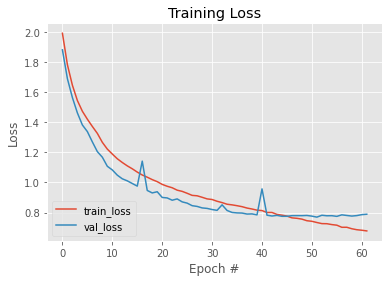

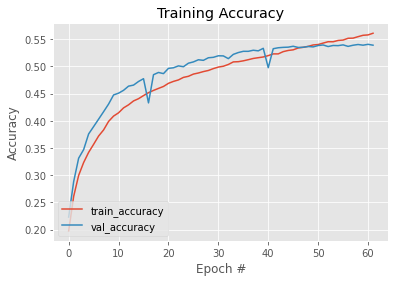

In [ ]:
model = train(train_datasets, test_datasets, keydelay_tokens, keytext_tokens)

# Testing Process

In [ ]:
# inference(test_datasets, keydelay_tokens, keytext_tokens)
# beam_search_inference(test_datasets, keydelay_tokens, keytext_tokens)

In [ ]:
beam_result = evaluate_beam(test_datasets, keydelay_tokens, keytext_tokens, top_n=50)

Streaming output truncated to the last 5000 lines.
Baseline Accuracy: 71.24%
Dataset: 2011/3068
Input sentence: weapons
[INFO] Camstroke hit the correct password with 39 guess(es)!
Total Correct: 1433
Baseline Accuracy: 71.26%
Dataset: 2012/3068
Input sentence: anyways
[INFO] Camstroke hit the correct password with 26 guess(es)!
Total Correct: 1434
Baseline Accuracy: 71.27%
Dataset: 2013/3068
Input sentence: before
[INFO] Camstroke hit the correct password with 12 guess(es)!
Total Correct: 1435
Baseline Accuracy: 71.29%
Dataset: 2014/3068
Input sentence: player
[INFO] Camstroke hit the correct password with 38 guess(es)!
Total Correct: 1436
Baseline Accuracy: 71.30%
Dataset: 2015/3068
Input sentence: sirius
Total Correct: 1436
Baseline Accuracy: 71.27%
Dataset: 2016/3068
Input sentence: people
[INFO] Camstroke hit the correct password with 12 guess(es)!
Total Correct: 1437
Baseline Accuracy: 71.28%
Dataset: 2017/3068
Input sentence: continue
Total Correct: 1437
Baseline Accuracy: 71.24

In [ ]:
base_result = evaluate_base(test_datasets, keydelay_tokens, keytext_tokens, word_dictionary, top_n=50)

Streaming output truncated to the last 5000 lines.
Input sentence: nothing
Total Correct: 499
Baseline Accuracy: 26.28%
Dataset: 1900/3068
Input sentence: stretch
Total Correct: 499
Baseline Accuracy: 26.26%
Dataset: 1901/3068
Input sentence: weekend
[INFO] Baseline hit the correct password with 37 guess(es)!
Total Correct: 500
Baseline Accuracy: 26.30%
Dataset: 1902/3068
Input sentence: favorite
Total Correct: 500
Baseline Accuracy: 26.29%
Dataset: 1903/3068
Input sentence: together
Total Correct: 500
Baseline Accuracy: 26.27%
Dataset: 1904/3068
Input sentence: stargate
Total Correct: 500
Baseline Accuracy: 26.26%
Dataset: 1905/3068
Input sentence: wanted
Total Correct: 500
Baseline Accuracy: 26.25%
Dataset: 1906/3068
Input sentence: vijaya
Total Correct: 500
Baseline Accuracy: 26.23%
Dataset: 1907/3068
Input sentence: account
[INFO] Baseline hit the correct password with 9 guess(es)!
Total Correct: 501
Baseline Accuracy: 26.27%
Dataset: 1908/3068
Input sentence: reading
Total Correct

### Store the Evaluation Result

In [ ]:
keys = beam_result[0].keys()

with open(f'{model_path}/beam_evaluation_all_top50.csv', 'w', newline='') as output_file:
    dict_writer = csv.DictWriter(output_file, keys)
    dict_writer.writeheader()
    dict_writer.writerows(beam_result)

In [ ]:
keys = base_result[0].keys()

with open(f'{model_path}/base_evaluation_all_top50.csv', 'w', newline='') as output_file:
    dict_writer = csv.DictWriter(output_file, keys)
    dict_writer.writeheader()
    dict_writer.writerows(base_result)

# Evaluation Analysis

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns

In [41]:
eval_data_path = "./drive/MyDrive/S2/camstroke-inference-models/s2s_model_beamsearch_CMUandVillani_RockyouText_v1"
beam_eval_path = f"{eval_data_path}/beam_evaluation_all_top50.csv"
base_eval_path = f"{eval_data_path}/base_evaluation_all_top50.csv"

beam_df = pd.read_csv(beam_eval_path)
base_df = pd.read_csv(base_eval_path)

beam_df['text_length']  = beam_df['y_actual'].str.len()
base_df['text_length']  = base_df['y_actual'].str.len()

beam_df

,type,pos,y_pred,y_actual,text_length
0,beam_search,3,nature,nature,6
1,beam_search,8,weekend,weekend,7
2,beam_search,3,ground,ground,6
3,beam_search,10,august,august,6
4,beam_search,3,ground,ground,6
...,...,...,...,...,...
2194,beam_search,3,laundry,laundry,7
2195,beam_search,11,movies,movies,6
2196,beam_search,2,really,really,6
2197,beam_search,6,friends,friends,7


## Number of Attempts

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


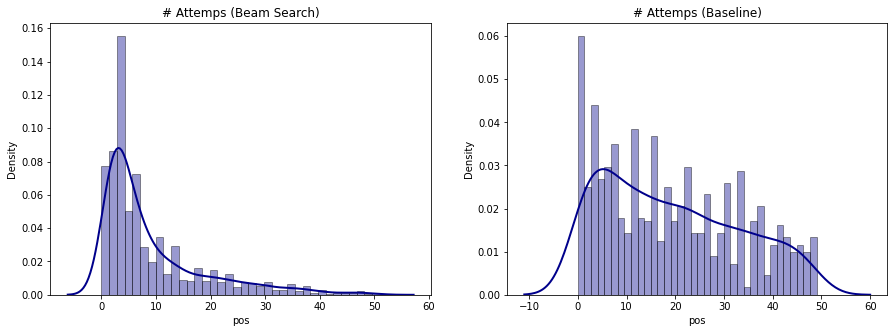

In [39]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

sns.distplot(beam_df['pos'], norm_hist=False, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             ax=ax[0]).set(title='# Attemps (Beam Search)')

sns.distplot(base_df['pos'], norm_hist=False, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             ax=ax[1]).set(title='# Attemps (Baseline)')
fig.show()

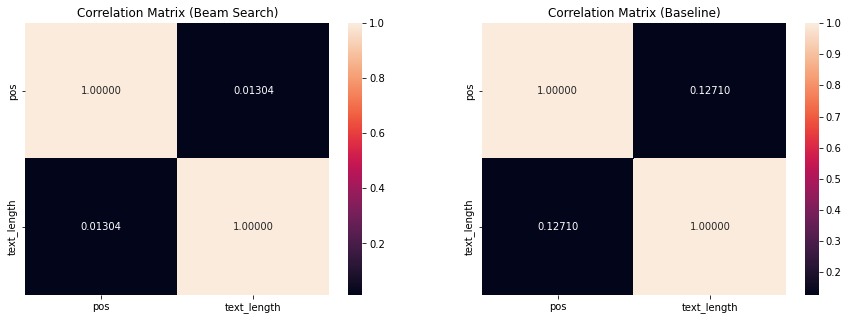

In [56]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

beam_corr = beam_df.corr()
sns.heatmap(beam_corr, 
            xticklabels=beam_corr.columns.values,
            yticklabels=beam_corr.columns.values,
            annot=True, fmt = '.5f',
            ax=ax[0]).set(title='Correlation Matrix (Beam Search)')

base_corr = base_df.corr()
sns.heatmap(base_corr, 
            xticklabels=base_corr.columns.values,
            yticklabels=base_corr.columns.values,
            annot=True, fmt = '.5f',
            ax=ax[1]).set(title='Correlation Matrix (Baseline)')

fig.show()